In [ ]:
!pip install transformers==4.24.0
!pip install simpletransformers==0.63.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score

from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
import sklearn

In [ ]:
cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc


def data_loader(filename):
    df = pd.read_csv(filename)
    df.drop(['Unnamed: 0'],axis=1,inplace=True)


    counts = df['medical_specialty'].value_counts()
    others = [k for k,v in counts.items() if v<100]
    for each_spec in others:
        df.loc[df['medical_specialty']==each_spec,'medical_specialty']=' others'

    counts = df['medical_specialty'].value_counts()

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    df['transcription'] = df['keywords']+df['transcription']
    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    class_weights = [1]*num_classes

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict

In [ ]:
cuda_available

True

In [ ]:
if __name__ == '__main__':
    train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader("/content/mtsamples.csv")

    train_df = pd.DataFrame(columns=['text','labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text','labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']


    learning_rate = 1e-5
    num_of_epochs = 3

    model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda = False,
        args=model_args
        )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)

    result, output = model.predict(test_df['text'].values.tolist())

    acc, f1 = eval_metrics(test_df['labels'], result)

    print(acc,f1)

                                                  text  labels
685  surgery, inguinal herniorrhaphy, modified bass...       5
231  surgery, sterilization, laparoscopic bilateral...       5
656  surgery, adhesions, peritoneum, purulent debri...       5
343  surgery, renal stone, stent removal, upj stone...       5
654  surgery, appendix, endobag, laparoscopic appen...       5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/2923 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/366 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/366 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

0.9801085748184738 0.9866666666666668


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class_dict.keys()

dict_keys([' others', ' Cardiovascular / Pulmonary', ' Neurology', ' Urology', ' General Medicine', ' Surgery', ' SOAP / Chart / Progress Notes', ' Radiology', ' Orthopedic', ' Obstetrics / Gynecology', ' Gastroenterology', ' Discharge Summary', ' Consult - History and Phy.'])

In [ ]:
# Compute accuracy and f1 score


acc, f1 = eval_metrics(test_df['labels'],result)

print(f' Accuracy = {acc} \n F1 Score = {f1}')

 Accuracy = 0.9801085748184738 
 F1 Score = 0.9866666666666668


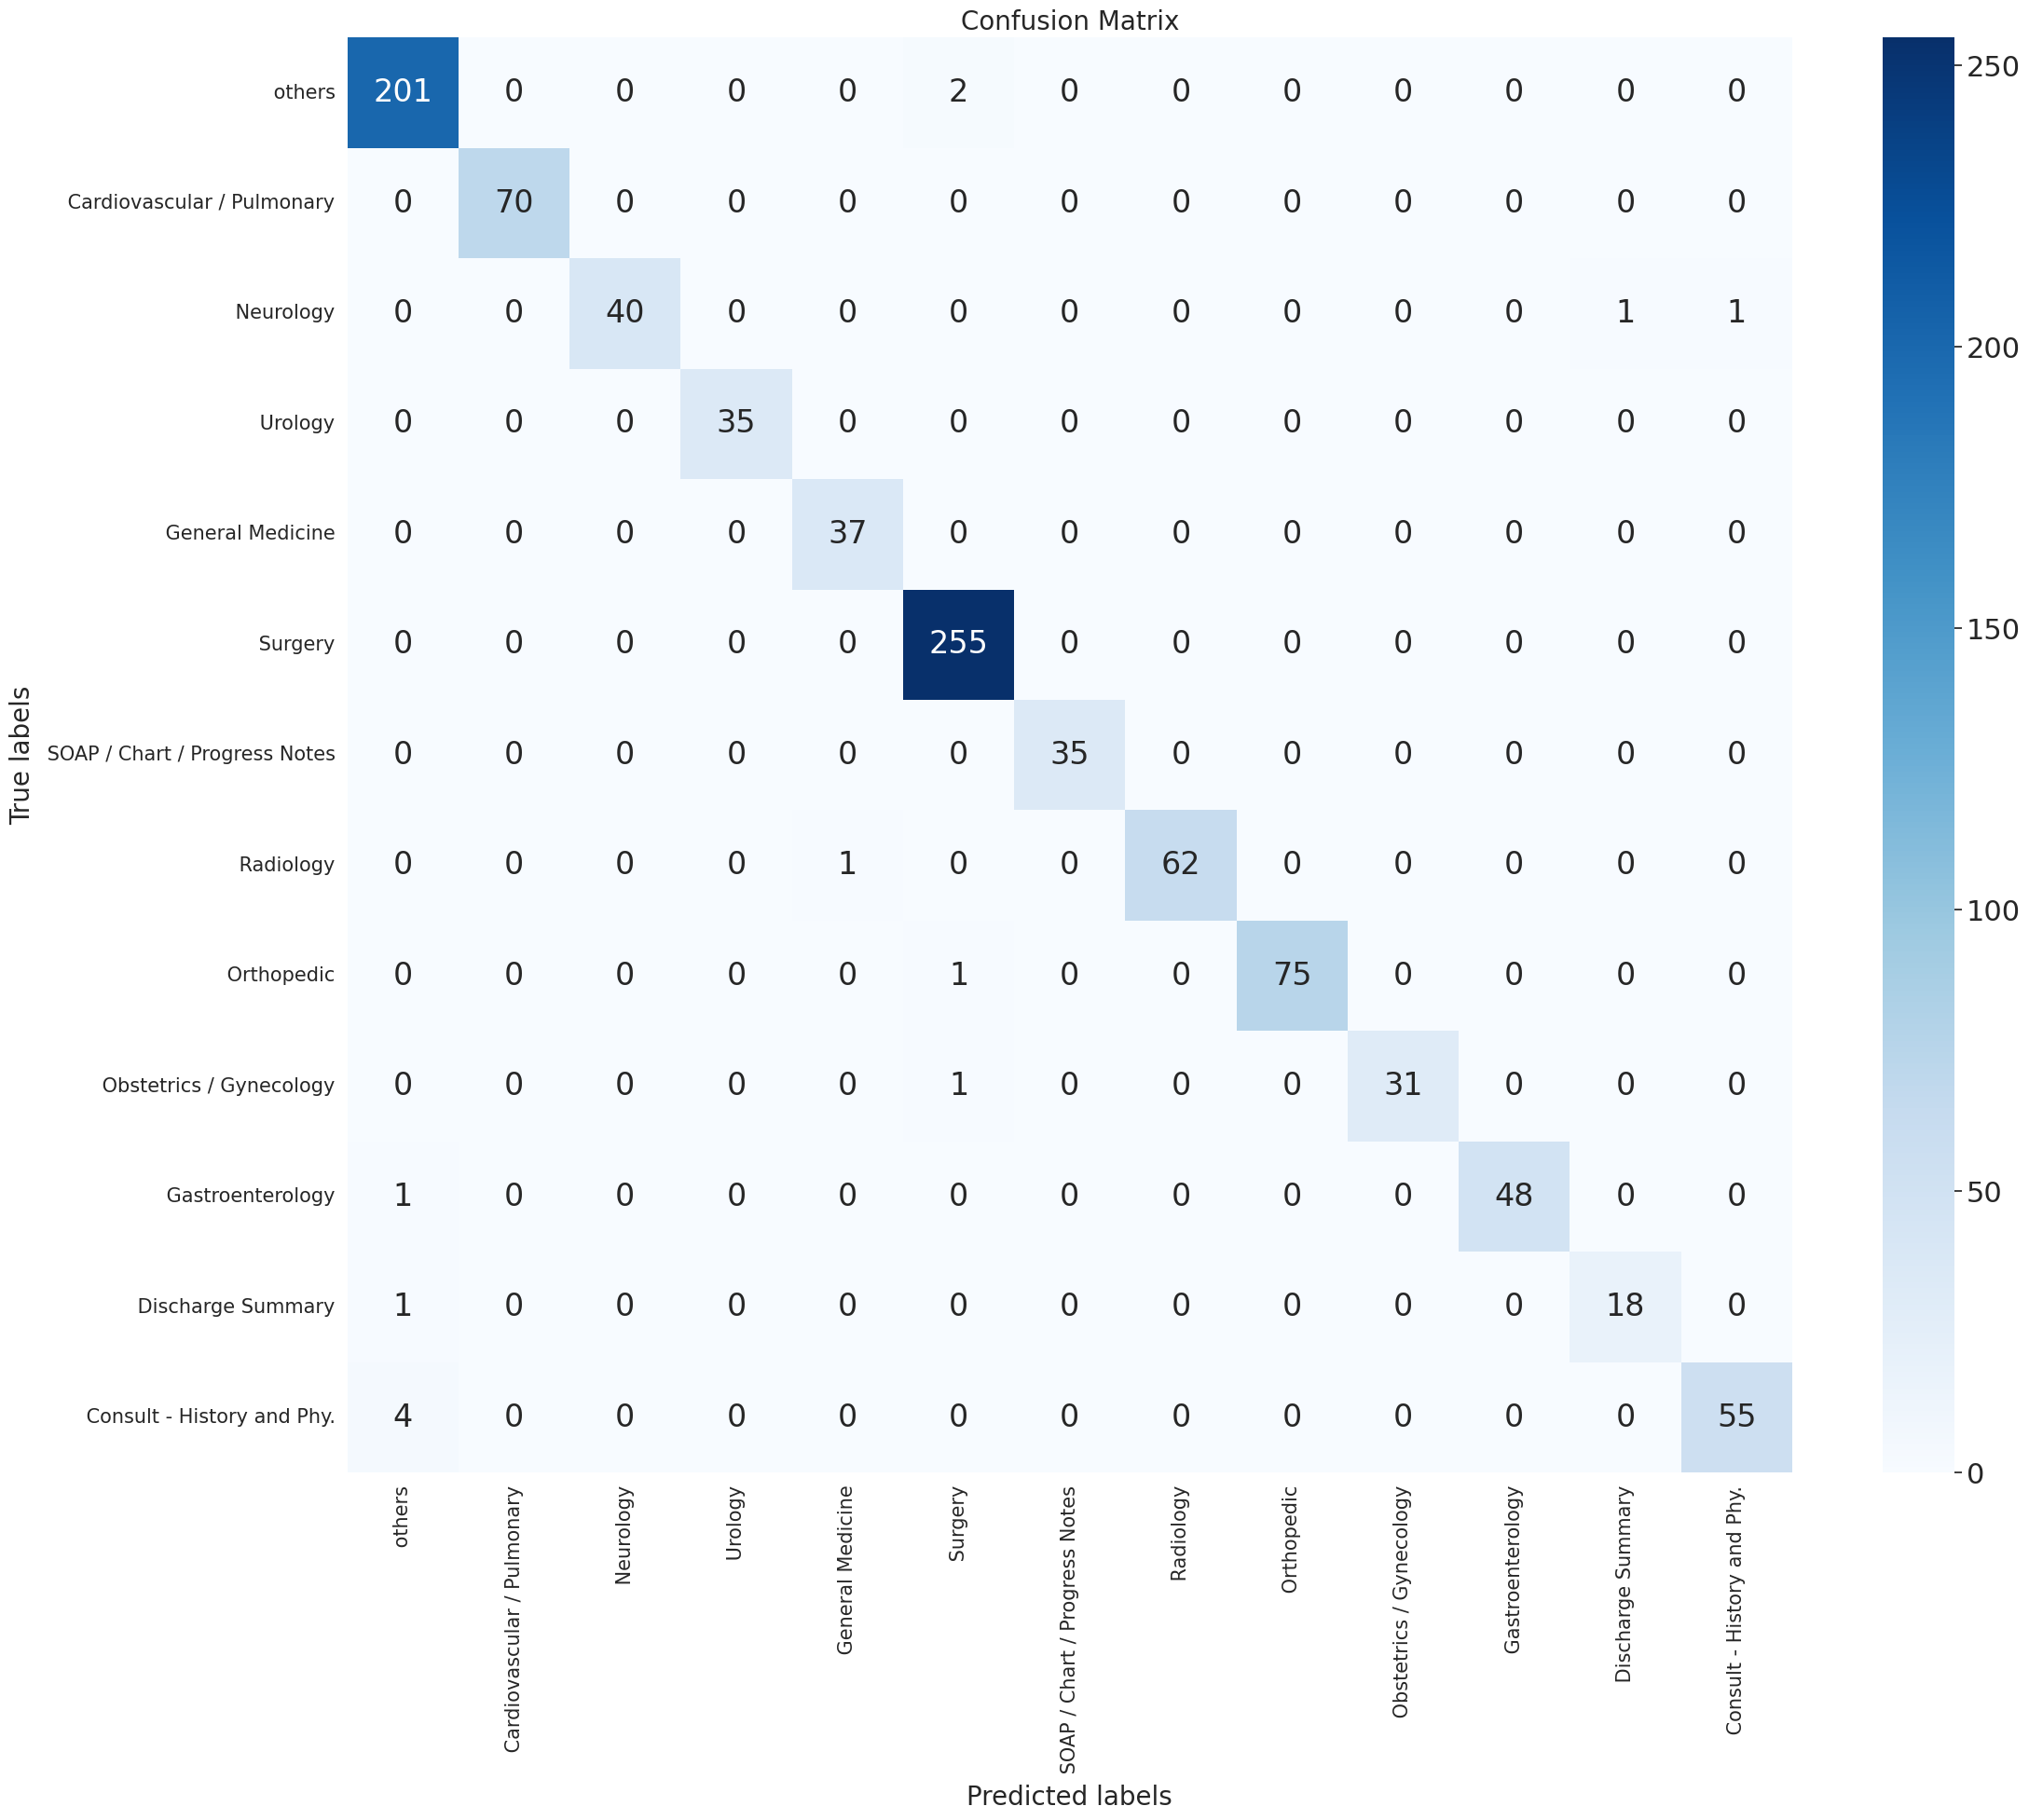

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_df['labels'], result)

plt.figure(figsize=(25, 20))
ax = plt.subplot()
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)

ax.set_title('Confusion Matrix', fontsize=20)

ax.xaxis.set_ticklabels(class_dict.keys(), fontsize=15, rotation = 90)
ax.yaxis.set_ticklabels(class_dict.keys(), fontsize=15, rotation = 0)

plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_df['labels'], result, target_names=class_dict.keys()))


                                precision    recall  f1-score   support

                        others       0.97      0.99      0.98       203
    Cardiovascular / Pulmonary       1.00      1.00      1.00        70
                     Neurology       1.00      0.95      0.98        42
                       Urology       1.00      1.00      1.00        35
              General Medicine       0.97      1.00      0.99        37
                       Surgery       0.98      1.00      0.99       255
 SOAP / Chart / Progress Notes       1.00      1.00      1.00        35
                     Radiology       1.00      0.98      0.99        63
                    Orthopedic       1.00      0.99      0.99        76
       Obstetrics / Gynecology       1.00      0.97      0.98        32
              Gastroenterology       1.00      0.98      0.99        49
             Discharge Summary       0.95      0.95      0.95        19
    Consult - History and Phy.       0.98      0.93      0.96  